In [1]:

import hydra
import sys
sys.path.insert(0, "./src")

# hydra can only be initialized once
hydra.initialize(config_path="configs", version_base=None)

hydra.initialize()

In [11]:
from models.loupe.configuration_loupe import LoupeConfig
from models.loupe.modeling_loupe import LoupeModel
from models.loupe.image_precessing_loupe  import LoupeImageProcessor
from lit_model import LitModel

# NOTE: set stage and checkpoint path here
cfg = hydra.compose(config_name="base", overrides=["stage=seg"])
cfg.ckpt.checkpoint_paths = ["/gemini/code/loupe/checkpoints/seg/model.safetensors"]
loupe_config = LoupeConfig(stage=cfg.stage.name, **cfg.model)
loupe = LoupeModel(loupe_config)
model = LitModel(cfg, loupe)
processor = LoupeImageProcessor(loupe_config)


2025-05-16 11:28:24.065 | INFO     | models.loupe.modeling_loupe:__init__:614 - Loading backbone from /gemini/code/loupe/pretrained_weights/pe/PE-Core-L14-336.pt


Missing keys for loading vision encoder: []
Unexpected keys for loading vision encoder: ['proj']


2025-05-16 11:28:50.693 | INFO     | lit_model:__init__:46 - Loading checkpoint from /gemini/code/loupe/checkpoints/seg/model.safetensors


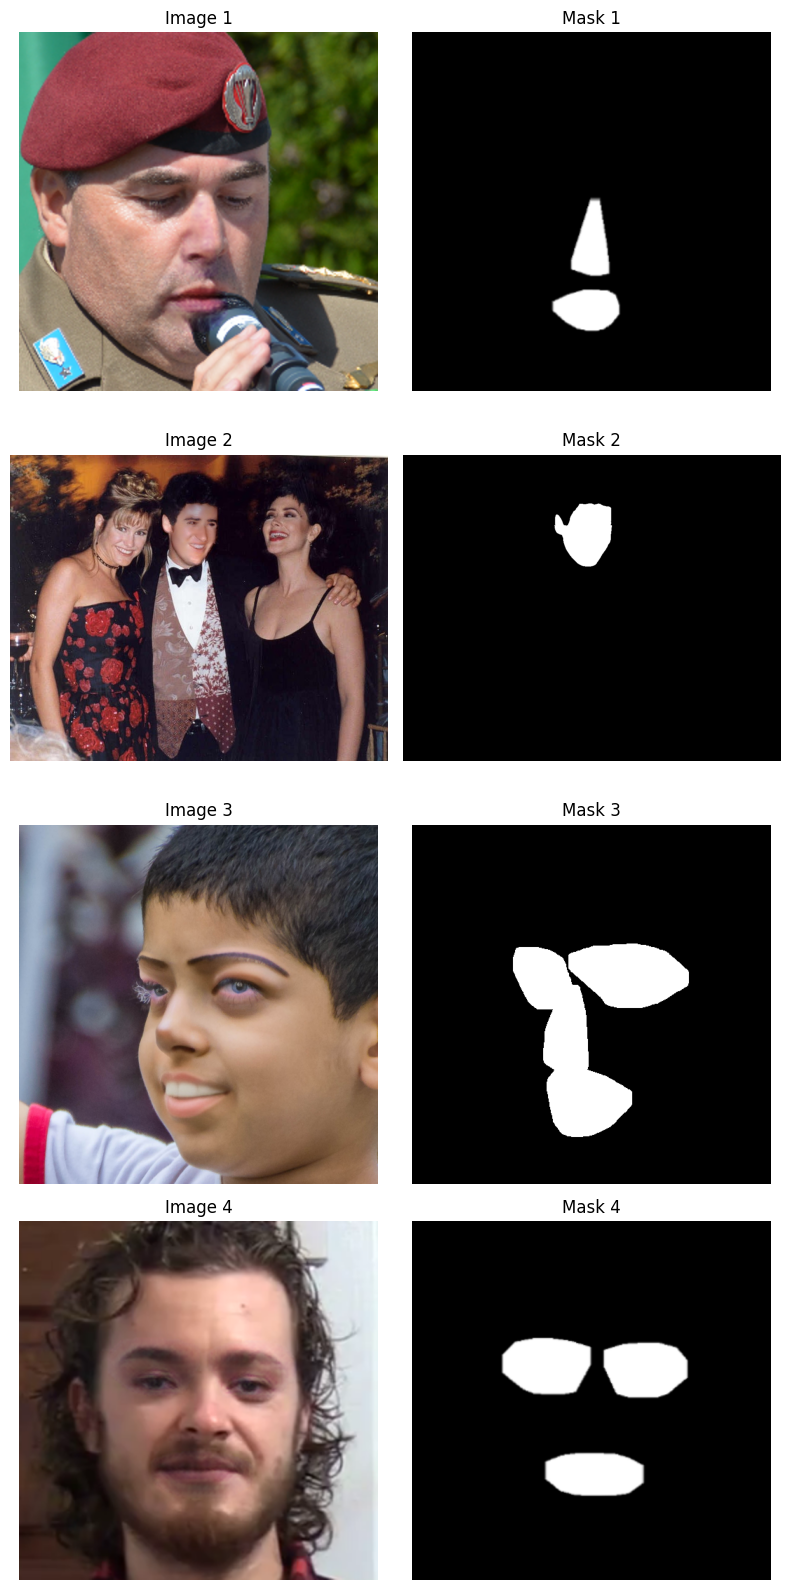

In [12]:
import os
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

validset = load_dataset(
    "parquet", data_files=os.path.join(cfg.data_dir, "valid.parquet")
)
num_pairs = 4

images, masks = [], []
for i in range(num_pairs):
    item = validset["train"][i]
    image = item["image"].convert("RGB")
    mask = item["mask"].convert("L") if item["mask"] is not None else None

    if mask is None:
        if isinstance(image, np.ndarray):
            mask = np.zeros_like(image)
        else:
            mask = np.zeros(image.size[::-1], dtype=np.uint8)

    images.append(image)
    masks.append(mask)

fig, axes = plt.subplots(num_pairs, 2, figsize=(8, 4 * num_pairs))

if num_pairs == 1:
    axes = np.expand_dims(axes, axis=0)

for idx, (img, msk) in enumerate(zip(images, masks)):
    axes[idx, 0].imshow(img)
    axes[idx, 0].set_title(f"Image {idx+1}")
    axes[idx, 0].axis("off")

    axes[idx, 1].imshow(msk, cmap="gray")
    axes[idx, 1].set_title(f"Mask {idx+1}")
    axes[idx, 1].axis("off")

plt.tight_layout()
plt.show()

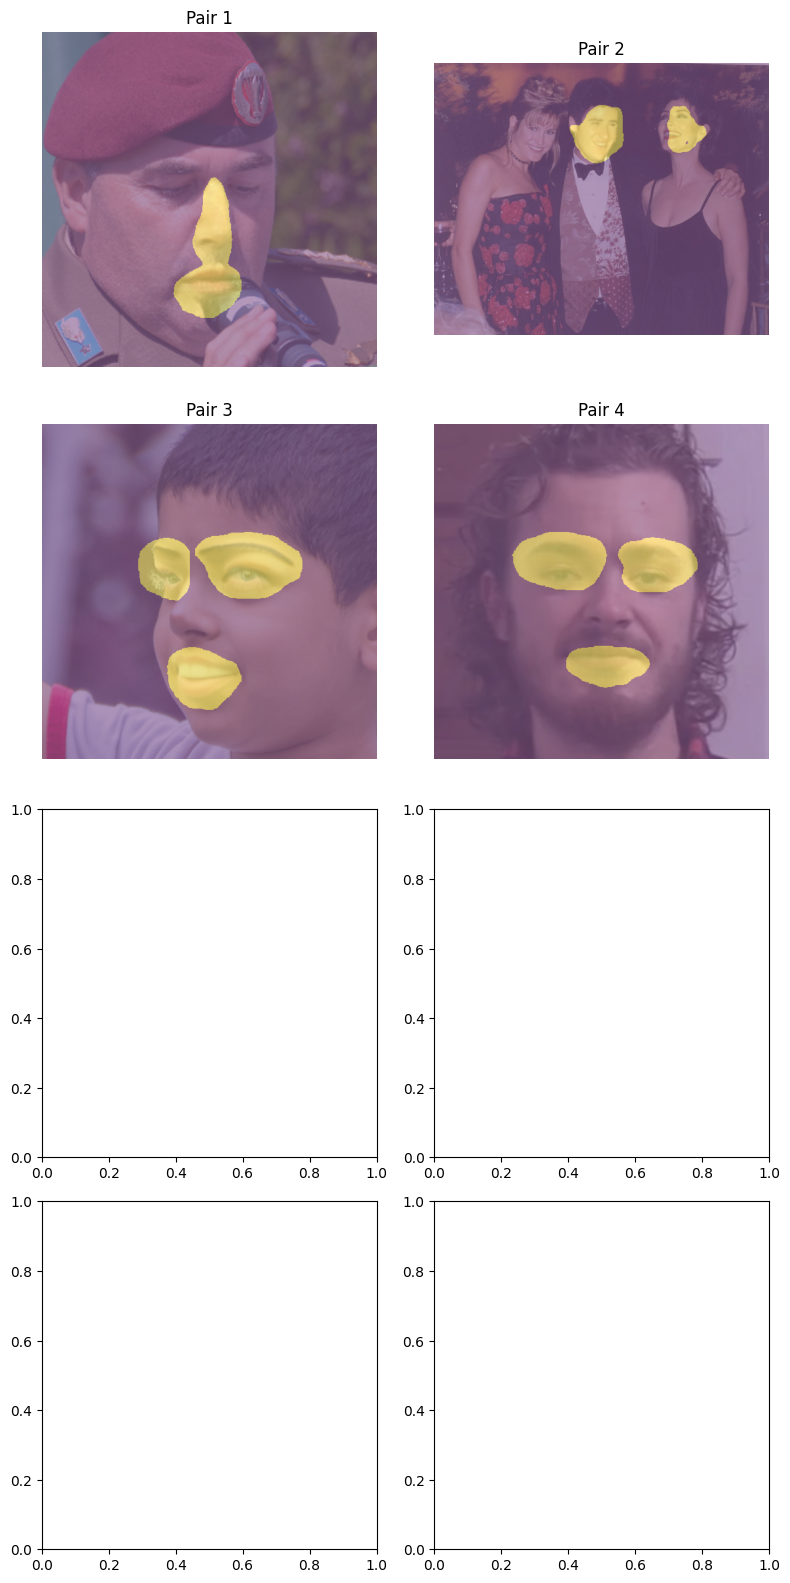

In [ ]:
import numpy as np
import torch
from PIL import Image

def predict(images):
    seg, cls_probs = [], []
    if "seg" in cfg.stage.name or cfg.stage.name == "test":
        inputs = processor(images, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
        segmentation = processor.post_process_segmentation(
            outputs, target_sizes=[image.size[::-1] for image in images]
        )
        seg = [
            Image.fromarray(
                torch.where(seg == 0, 255, 0).numpy().astype(np.uint8)
            ).convert("L")
            for seg in segmentation
        ]
    if "cls" in cfg.stage.name or cfg.stage.name == "test":
        inputs = processor(images, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
        cls_probs = torch.sigmoid(outputs.cls_logits).tolist()

    return seg, cls_probs

seg, cls_probs = predict(images)
fig, axes = plt.subplots(num_pairs, 2, figsize=(8, 4 * num_pairs))
if num_pairs == 1:
    axes = np.expand_dims(axes, axis=0)

for idx, (img1, img2) in enumerate(zip(images, seg)):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    ax.imshow(img1, alpha=0.6)
    ax.imshow(img2, alpha=0.4)
    ax.set_title(f"Pair {idx+1}")
    ax.axis('off')

if num_pairs % 2 != 0:
    for i in range(num_pairs, num_pairs + 1):
        fig.delaxes(axes[i // 2, i % 2])

plt.tight_layout()
plt.show()